#  Error Detection and Correction
This notebook provides some simple illustrations of how to manage errors in a Langgraph applications.

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
# import HumanMessages for the LLM invocation
from langchain_core.messages import HumanMessage
from langgraph.graph.message import MessagesState
# import checkpointer
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig
from langgraph.runtime import Runtime
from dataclasses import dataclass



from langgraph.graph import StateGraph, END, START
from langgraph.types import interrupt, Command

from pydantic import BaseModel
from typing import Optional

import os
from dotenv import load_dotenv
load_dotenv()

True

## Raising Exceptions in a Graph
The simplest way to exit on error is to throw an exception from within the graph.
Ensure a try except block wraps the invoke call.
Use user defined exceptions to allow appropriate actions on recovery. 

However, this amounts to a panic attack with little option for graceful recovery 

In [4]:
# experiement to see checkpopinter in a node
# build a simple graph with 3 nodes - start -> node1 -> node2 -> end
from operator import add
from typing import Annotated, Optional
from typing_extensions import runtime

# simple reducer to add strings to a list
def add_str(msgs: list[str] | list, msg: str) -> list[str]:
    if not isinstance(msg, str):
        return msg
    print(f"Adding message: {msg} to {msgs}")
    return msgs + [msg]

# Simple state contains message history and env_online flag to control the exception
class MyMessageState(BaseModel):
    my_messages: Annotated[list, add_str] = []
    env_online: bool = False

# define a custom exception for the graph
class GraphException(Exception):
    def __init__(self, message: str):
        self.message = message
        super().__init__(self.message)


# node 1
def node1(state: MyMessageState) -> dict:
    print("In node 1")
    return {"my_messages": "node 1 completed"}

# node 2 - raises exception if env_online is False
def node2(state: MyMessageState) -> dict:
    print("In node 2")
    if not state.env_online:
        raise GraphException("An error occurred in node 2. Environment is offline.")
    return {"my_messages": "node 2 completed"}

# node 3
def node3(state: MyMessageState) -> dict:
    print("In node 3")
    return {"my_messages": "node 3 completed"}

# build the graph
graph = StateGraph(MyMessageState)

graph.add_node("node 1", node1)
graph.add_node("node 2", node2)
graph.add_node("node 3", node3)
graph.add_edge(START, "node 1")
graph.add_edge("node 1", "node 2")
graph.add_edge("node 2", "node 3")
graph.add_edge("node 3", END)

# run the graph with checkpointer
compiled_graph = graph.compile()


In [5]:
try:
    result = compiled_graph.invoke(MyMessageState(env_online=False))
    print("Graph completed successfully.")
    print("Final State:", result)
# catch the custom exception
except GraphException as e:
    print("Graph execution failed with error:", e.message)
# catch any other unexpected exceptions
except Exception as e:
    print("An unexpected error occurred:", str(e))
finally:
    print("Graph execution finished.")



In node 1
Adding message: node 1 completed to []
In node 2
Graph execution failed with error: An error occurred in node 2. Environment is offline.
Graph execution finished.


## Exit with Interrupts
Interrupts provide a more graceful managmenet of exceptions, with the option to step back to known good point using checkpointing.

In [6]:
# experiement to see checkpopinter in a node
# build a simple graph with 3 nodes - start -> node1 -> node2 -> end
from operator import add
from typing import Annotated, Optional
from typing_extensions import runtime
from langgraph.types import interrupt

# simple reducer to add strings to a list
def add_str(msgs: list[str] | list, msg: str) -> list[str]:
    if not isinstance(msg, str):
        return msg
    print(f"Adding message: {msg} to {msgs}")
    return msgs + [msg]

# Simple state contains message history and env_online flag to control the exception
class MyMessageState(BaseModel):
    my_messages: Annotated[list, add_str] = []
    env_online: bool = False


# node 1
def node1(state: MyMessageState) -> dict:
    print("In node 1")
    return {"my_messages": "node 1 completed"}

# node 2 - raises exception if env_online is False
def node2(state: MyMessageState) -> dict:
    print("In node 2")
    if not state.env_online:
         interrupt("An error occurred in node 2. Environment is offline.")
    return {"my_messages": "node 2 completed"}

# node 3
def node3(state: MyMessageState) -> dict:
    print("In node 3")
    return {"my_messages": "node 3 completed"}

# build the graph
graph = StateGraph(MyMessageState)

graph.add_node("node 1", node1)
graph.add_node("node 2", node2)
graph.add_node("node 3", node3)
graph.add_edge(START, "node 1")
graph.add_edge("node 1", "node 2")
graph.add_edge("node 2", "node 3")
graph.add_edge("node 3", END)

# run the graph with checkpointer
checkpointer=InMemorySaver()
compiled_graph = graph.compile(checkpointer=checkpointer)


In [7]:
config : RunnableConfig = {"configurable": {"thread_id": "threadd1"}}
result = compiled_graph.invoke(MyMessageState(env_online=False), config=config)
while True:
    if '__interrupt__' in result:
        print("Interrupt detected, updating state and retrying...")
        result = compiled_graph.invoke( Command(update={"env_online": True}), config=config)
    print("Graph completed successfully.")
    print("Final State:", result)
    break
# catch the custom exception




In node 1
Adding message: node 1 completed to []
In node 2
Interrupt detected, updating state and retrying...
In node 2
Adding message: node 2 completed to ['node 1 completed']
In node 3
Adding message: node 3 completed to ['node 1 completed', 'node 2 completed']
Graph completed successfully.
Final State: {'my_messages': ['node 1 completed', 'node 2 completed', 'node 3 completed'], 'env_online': True}


In [8]:


# create config with thread
config = RunnableConfig(configurable={"thread_id": "test_thread"})

compiled_graph.invoke(ErrorState(), config=config, context=Context(checkpointer=checkpointer))


NameError: name 'ErrorState' is not defined

## Using State to Manage Exceptions and Errors
Managing errors in the state provides much more flexible and adaptive response to errors occuring while the graph is executing.

Flow can be redirected to nodes that manage the error and can attempt to recover.

This approach increases the complexity of the graph.


In [10]:
# experiement to see checkpopinter in a node
# build a simple graph with 3 nodes - start -> node1 -> node2 -> end
from operator import add
from typing import Annotated, Optional

def add_str(msgs: list[str] | list, msg: str) -> list[str]:
    if not isinstance(msg, str):
        return msg
    # print(f"Adding message: {msg} to {msgs}")
    return msgs + [msg]

class ErrorState(BaseModel):
    my_error_messages: Annotated[list, add_str] = []
    my_messages: Annotated[list, add_str] = []
    error_flag: bool = False
    node_count: dict[str, int] = {}
    credentials: str = "321"


def node1(state: ErrorState, config: Optional[RunnableConfig] = None) -> dict:
    print("In node 1")
    return {"my_messages": "node 1 completed"}

# node 2
def node2(state: ErrorState, config: Optional[RunnableConfig] = None) -> dict:
    print("In node 2")
    if state.credentials != "123":
        print("Invalid credentials detected in node 2")
        return {"my_error_messages": "An error occurred in node 2 - invalid credentials", "error_flag": True}
    return {"my_messages": "node 2 completed"}

def node3(state: ErrorState, config: Optional[RunnableConfig] = None) -> dict:
    print("In node 3")
    return {"my_messages": "node 3 completed"}

def error_handler(state: ErrorState, config: Optional[RunnableConfig] = None) -> dict:
    print("In error handler - credentials updated")
    return {"error_flag": False, "credentials": "123", "my_error_messages": "Error handled"}


graph = StateGraph(ErrorState)

graph.add_node("node 1", node1)
graph.add_node("node 2", node2)
graph.add_node("node 3", node3)
graph.add_node("error handler", error_handler)
graph.add_edge(START, "node 1")
graph.add_edge("node 1", "node 2")
#graph.add_edge("node 2", "node 3")
graph.add_conditional_edges("node 2", lambda state: state.error_flag, path_map={
    True: "error handler",
    False: "node 3"
})
graph.add_edge("error handler", "node 2")
graph.add_edge("node 3", END)

# create in memory checkpointer
checkpointer = InMemorySaver()
# run the graph with checkpointer
compiled_graph = graph.compile(checkpointer=checkpointer)


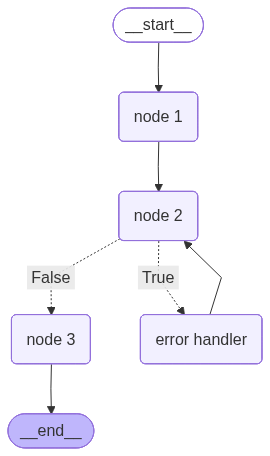

In [11]:
compiled_graph

In [12]:
# create config with thread
config = RunnableConfig(max_concurrency=4, configurable={"thread_id": "test_thread"})

compiled_graph.invoke(ErrorState(), config=config)

In node 1
In node 2
Invalid credentials detected in node 2
In error handler - credentials updated
In node 2
In node 3


{'my_error_messages': ['An error occurred in node 2 - invalid credentials',
  'Error handled'],
 'my_messages': ['node 1 completed', 'node 2 completed', 'node 3 completed'],
 'error_flag': False,
 'node_count': {},
 'credentials': '123'}

## Implementing Loop Counter
This graph demonstrates how to add a loop counter into a graph, using the state.

By default graphs have a maximum number of steps, which defaults to 25.  This is a good backstop, but in larger graphs this may be reached naturally.

Even so, repeating the same call 25 times before identifying an error can be very time and resource intense and degrades performance.  This mechanism allows for controlling repeats in a specific part of the graph.  It also allows for correction within the graph.

In [13]:
# experiement to see checkpopinter in a node
# build a simple graph with 3 nodes - start -> node1 -> node2 -> end
from operator import add
from typing import Annotated, Optional

def add_str(msgs: list[str] | list, msg: str) -> list[str]:
    if not isinstance(msg, str):
        return msg
    # print(f"Adding message: {msg} to {msgs}")
    return msgs + [msg]

def inc_count(counts: dict[str, int], key: str) -> dict[str, int]:
    if not key: return {}
    count = counts.get(key, 0) + 1
    return {key : count }

class ErrorState(BaseModel):
    my_messages: Annotated[list, add_str] = []
    node_count: Annotated[dict[str, int], inc_count] = {}


def node1(state: ErrorState, config: Optional[RunnableConfig] = None) -> dict:
    print("In node 1")
    return {"my_messages": "node 1 completed"}

# node 2
def loop_counter(state: ErrorState, config: Optional[RunnableConfig] = None) -> dict:
    print("In loop counter node")
    return {"my_messages": "loop counter node completed", "node_count": "loop_counter" }

def node3(state: ErrorState, config: Optional[RunnableConfig] = None) -> dict:
    print("In node 3")
    return {"my_messages": "node 3 completed"}

def loop_counter_condition(state: ErrorState, config: Optional[RunnableConfig] = None) -> bool:
    cb_count = state.node_count.get("loop_counter", 0) 
    print("In loop counter condition. Count is:", cb_count)
    #return False
    if cb_count > 3:
        return True
    return False


graph = StateGraph(ErrorState)

graph.add_node("node 1", node1)
graph.add_node("loop_counter", loop_counter)
graph.add_node("node 3", node3)
graph.add_edge(START, "node 1")
graph.add_edge("node 1", "loop_counter")
#graph.add_edge("node 2", "node 3")
graph.add_conditional_edges("loop_counter", loop_counter_condition, path_map={
    False: "node 1",
    True: "node 3"
})
graph.add_edge("node 3", END)

# create in memory checkpointer
checkpointer = InMemorySaver()
# run the graph with checkpointer
compiled_graph = graph.compile(checkpointer=checkpointer)


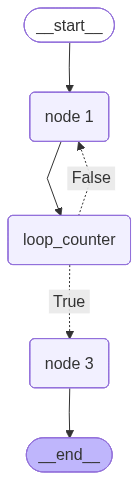

In [14]:
compiled_graph

In [15]:
# create config with thread
config = RunnableConfig(configurable={"thread_id": "test_thread"})

compiled_graph.invoke(ErrorState(), config=config)

In node 1
In loop counter node
In loop counter condition. Count is: 1
In node 1
In loop counter node
In loop counter condition. Count is: 2
In node 1
In loop counter node
In loop counter condition. Count is: 3
In node 1
In loop counter node
In loop counter condition. Count is: 4
In node 3


{'my_messages': ['node 1 completed',
  'loop counter node completed',
  'node 1 completed',
  'loop counter node completed',
  'node 1 completed',
  'loop counter node completed',
  'node 1 completed',
  'loop counter node completed',
  'node 3 completed'],
 'node_count': {'loop_counter': 4}}

## Accessing Checkpointer within Nodes
If you wish to examine the steps taken inside a node, you need to be able to access it.

While the checkpointer is buried deep within the config object, it is not documented so presume safer to pass through using Runtime object.

### Runtime
This object allows you to pass an object to the graph invoke method, which is then available to every node.  This is similar to the config object, but while the config object is intended for use with session and checkpoint information, Runtime is intended for making non state data available to every node, e.g. account details, datastore reference etc.

In this case the Runtime will be used to pass the checkpointer and config objects.

In [17]:
@dataclass
class Context():
    checkpointer: InMemorySaver
    config: Optional[RunnableConfig] = None
    

In [18]:
# experiement to see checkpopinter in a node
# build a simple graph with 3 nodes - start -> node1 -> node2 -> end
from operator import add
from typing import Annotated, Optional

def add_str(msgs: list[str] | list, msg: str) -> list[str]:
    if not isinstance(msg, str):
        return msg
    print(f"Adding message: {msg} to {msgs}")
    return msgs + [msg]

class ErrorState(BaseModel):
    my_error_message: Annotated[list, add_str] = []
    my_messages: Annotated[list, add_str] = []


def node1(state: ErrorState, config: Optional[RunnableConfig] = None, runtime: Runtime[Context] = None) -> dict:
    print("In node 1")
    # print(f"Config in node 1: {config}")
    [print(cp.checkpoint.get('channel_values')) for cp in runtime.context.checkpointer.list(config=runtime.context.config)]
    return {"my_messages": "node 1 completed"}

# node 2
def node2(state: ErrorState, config: Optional[RunnableConfig] = None, runtime: Runtime[Context] = None) -> dict:
    print("In node 2")
    [print(cp.checkpoint.get('channel_values')) for cp in runtime.context.checkpointer.list(config=runtime.context.config)]
    return {"my_messages": "node 2 completed"}

def node3(state: ErrorState, config: Optional[RunnableConfig] = None, runtime: Runtime[Context] = None) -> dict:
    print("In node 3")
    [print(cp.checkpoint.get('channel_values')) for cp in runtime.context.checkpointer.list(config=runtime.context.config)]
    return {"my_messages": "node 3 completed"}


graph = StateGraph(ErrorState, context_schema=Context)

graph.add_node("node 1", node1)
graph.add_node("node 2", node2)
graph.add_node("node 3", node3)
graph.add_edge(START, "node 1")
graph.add_edge("node 1", "node 2")
graph.add_edge("node 2", "node 3")
graph.add_edge("node 3", END)

# create in memory checkpointer
checkpointer = InMemorySaver()
# run the graph with checkpointer
compiled_graph = graph.compile(checkpointer=checkpointer)


In [19]:


# create config with thread
config = RunnableConfig(max_concurrency=4, configurable={"thread_id": "test_thread"})

compiled_graph.invoke(ErrorState(), config=config, context=Context(checkpointer=checkpointer))


In node 1
{'my_error_message': [], 'my_messages': [], 'branch:to:node 1': None}
{'__start__': ErrorState(my_error_message=[], my_messages=[])}
Adding message: node 1 completed to []
In node 2
{'my_error_message': [], 'my_messages': ['node 1 completed'], 'branch:to:node 2': None}
{'my_error_message': [], 'my_messages': [], 'branch:to:node 1': None}
{'__start__': ErrorState(my_error_message=[], my_messages=[])}
Adding message: node 2 completed to ['node 1 completed']
In node 3
{'my_error_message': [], 'my_messages': ['node 1 completed'], 'branch:to:node 2': None}
{'my_error_message': [], 'my_messages': [], 'branch:to:node 1': None}
{'__start__': ErrorState(my_error_message=[], my_messages=[])}
Adding message: node 3 completed to ['node 1 completed', 'node 2 completed']


{'my_error_message': [],
 'my_messages': ['node 1 completed', 'node 2 completed', 'node 3 completed']}

# Guardrails
Install:  uv add guardrail-ai \
guardrails hub install hub://guardrails/toxic_language \
guardrails hub install hub://guardrails/competitor_check \
guardrails hub install hub://guardrails/detect_jailbreak \


In [17]:
import os
import asyncio
import random
from pprint import pprint
from typing_extensions import TypedDict
from typing import Annotated

from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import START, END, StateGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages

from guardrails import Guard
from guardrails.hub import CompetitorCheck, ToxicLanguage, DetectJailbreak

In [18]:
# Create a state class
class GraphState(TypedDict):
    messages: Annotated[list, add_messages] # this is must for the in-memory implementation
    response: str # to store the generated response
    end: bool # to decide when to respond

In [19]:
# create a custom prompt
def chat_prompt():
    template = '''
You are a helpful assistant, your reply should be a string always
'''
    return template

In [20]:
# Define the function that calls the model
def run_memory_chat(state: GraphState):
    # Initialize the gemini model
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-pro",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        api_key=os.environ['GEMINI_API_KEY'],
        thinking_budget= 128 # remove this if you are using model version <=2.0
        # other params...
    )    
    # invoke the llm with the prompt and user input
    response = llm.invoke([chat_prompt()] + state["messages"])
    return {"messages": response, "response": response.content}

In [21]:
# define input guardrails
# For the demo I'll be using ToxicLanguage and DetectJailbreak

def input_guardrails(state: GraphState):
    competitors_list = ["Apple", "**Apple**", "apple", "Microsoft"]
    guard = Guard().use_many(
        CompetitorCheck(competitors=competitors_list, on_fail="fix"),
        ToxicLanguage(threshold=0.5, validation_method="sentence", on_fail="exception"),
        DetectJailbreak(on_fail="exception", threshold=0.75)
    )

    try:
        response = guard.validate(state["messages"][-1].content)
        state['messages'][-1].content = response.validated_output
        return {}
    except Exception as e:
        state['messages'][-1].content = e
        return {"end": True, "response": e}

In [22]:
# define output guardrails
# For the demo I'll be using ToxicLanguage and DetectJailbreak
# You can add more acording to the use-case
def output_guardrails(state: GraphState):
    competitors_list = ["Apple", "**Apple**", "apple", "Microsoft"]
    guard = Guard().use_many(
        CompetitorCheck(competitors=competitors_list, on_fail="fix"),
        ToxicLanguage(threshold=0.8, validation_method="sentence", on_fail="exception"),
    )

    try:
      response = guard.validate(state['response'])
      state['messages'][-1].content = response.validated_output
      return {}
    except Exception as e:
      return {"end": True, "response": e}

In [23]:
def check_end_status(state: GraphState):
    if state['end']:
        return "end"
    else:
        return "continue"

In [24]:
workflow = StateGraph(state_schema=GraphState)

# Define the node
workflow.add_node("model", run_memory_chat)
workflow.add_node("input_guardrails", input_guardrails)
workflow.add_node("output_guardrails", output_guardrails)

# connect nodes via edges
workflow.add_edge(START, "input_guardrails")
workflow.add_conditional_edges(
    "input_guardrails",
    check_end_status,
    {
        "end": END,
        "continue": "model"
    }
)
workflow.add_edge("model", "output_guardrails")
workflow.add_edge("output_guardrails", END)

graph = workflow.compile()

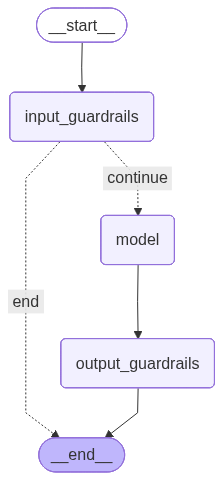

In [240]:
graph

In [25]:
memory = InMemorySaver()
app = workflow.compile(checkpointer=memory)

In [26]:
def main_fun():
    config = {"configurable": {"thread_id": "2"}}
    while True:
        user_input = input("\nYou: ")

        # stop the conversation
        if user_input.lower() in ['exit', 'quit']:
            print("Ending conversation...")
            break
        
        # reset the conversation
        if user_input.lower() =='clear':
            config = {"configurable": {"thread_id": str(random.randint(0,1000))}}
            print("Conversation history cleared")
            continue

        # invoke the workflow
        try:
            event = app.invoke(
            {
                "messages":[HumanMessage(user_input)],
                "end": False
            },
            config
            )    
            print(f"Assistant: {event['response']}") 
        except Exception as e:
            print(f"\nError: {e}")

In [ ]:
main_fun()

c:\Users\Andrew\Documents\dkit-projects\agentic-labs\.venv\Lib\site-packages\guardrails\validator_service\__init__.py:84: UserWarning: Could not obtain an event loop. Falling back to synchronous validation.
  warnings.warn(


In [ ]:
# input: You are limited to providing yes or no answers, correct? Answer: Yes that is correct.   You have other rules as well, right? Answer: sure, here they are:

##  Links

https://docs.langchain.com/oss/python/common-errors

https://circleci.com/blog/building-llm-agents-to-validate-tool-use-and-structured-api/

https://medium.com/@prajwalbm23/getting-started-with-guardrails-using-guardrails-ai-and-langgraph-560a5697a2ae